# KNMI daggegevens

https://www.knmi.nl/nederland-nu/klimatologie/daggegevens

In [516]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Set parameters

In [517]:
year = 2020

stations = {
    260: 'De Bilt',
    279: 'Hoogeveen'
}

vars = ['TG']

### Download data from url

In [518]:
start = f'{year}0101'
end = f'{year}1231'

url = 'https://www.daggegevens.knmi.nl/klimatologie/daggegevens' \
      '?stns=' + ':'.join(map(str, stations.keys())) + \
      '&vars=' + ':'.join(vars) + \
      '&start=' + start + \
      '&end=' + end

url

'https://www.daggegevens.knmi.nl/klimatologie/daggegevens?stns=260:279&vars=TG&start=20200101&end=20201231'

In [519]:
column_names = ['STN', 'YYYYMMDD'] + vars

df = pd.read_csv(url, 
                 comment = '#', 
                 names = column_names,
                 parse_dates = ['YYYYMMDD'])

print(df.shape)
display(df.head())

(732, 3)


,STN,YYYYMMDD,TG
0,260,2020-01-01,8
1,260,2020-01-02,39
2,260,2020-01-03,76
3,260,2020-01-04,67
4,260,2020-01-05,69


### or from downloaded files

In [520]:
filename1 = '../datasets/etmgeg_260.txt'    # De Bilt
filename2 = '../datasets/etmgeg_279.txt'    # Hoogeveen

In [521]:
kwargs = {'skiprows' : 47, 
          'skipinitialspace': True,
          'usecols': ['# STN', 'YYYYMMDD'] + vars,
          'parse_dates': ['YYYYMMDD']}

df1 = pd.read_csv(filename1, **kwargs).rename(columns = {'# STN':'STN'})
df2 = pd.read_csv(filename2, **kwargs).rename(columns = {'# STN':'STN'})

df = pd.concat([df1[df1['YYYYMMDD'].dt.year == year], 
                df2[df2['YYYYMMDD'].dt.year == year]]).reset_index(drop = True)

print(df.shape)
display(df.head())

(732, 3)


,STN,YYYYMMDD,TG
0,260,2020-01-01,8.0
1,260,2020-01-02,39.0
2,260,2020-01-03,76.0
3,260,2020-01-04,67.0
4,260,2020-01-05,69.0


## Convert columns

In [522]:
df['TEMPERATURE'] = df['TG'].astype('int') / 10

In [523]:
df['DD'] = pd.to_datetime(df['YYYYMMDD'], format='%Y%m%d')

In [524]:
df['STATION'] = df['STN'].astype('int').map(stations)

## Pivot to daily index

In [527]:
df_daily = df.pivot(index = 'DD', 
                    columns = 'STATION', 
                    values = 'TEMPERATURE')

In [528]:
df_daily

STATION,De Bilt,Hoogeveen
DD,,
2020-01-01,0.8,0.2
2020-01-02,3.9,1.8
2020-01-03,7.6,6.7
2020-01-04,6.7,5.3
2020-01-05,6.9,5.4
...,...,...
2020-12-27,5.0,4.4
2020-12-28,3.6,3.5
2020-12-29,3.7,3.2


# Visualisation

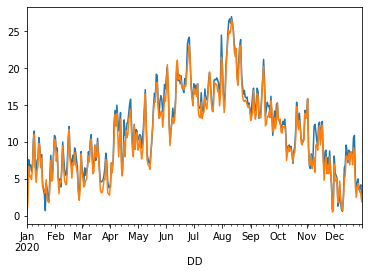

In [529]:
for station in stations.values():
    df_daily[station].plot()

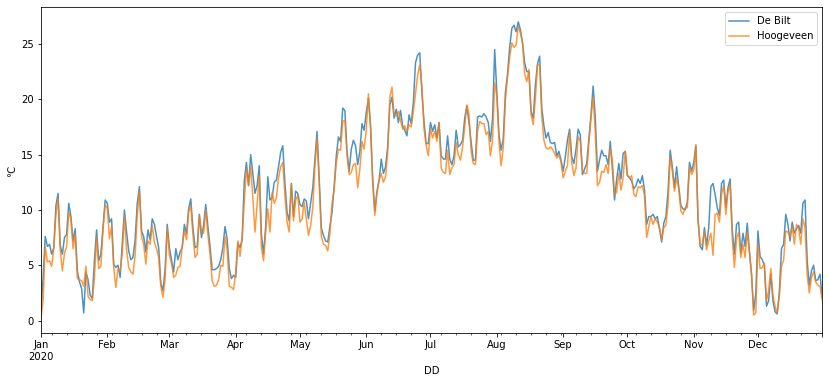

In [532]:
plt.figure(figsize=(14, 6))

for station in stations.values():
    df_daily[station].plot(alpha=0.8)

plt.ylabel('℃')
plt.legend(stations.values())
plt.show()

In [533]:
df_daily.describe()

STATION,De Bilt,Hoogeveen
count,366.000000,366.000000
mean,11.688251,10.928142
std,5.567863,5.529339
min,0.600000,0.200000
25%,7.300000,6.700000
50%,11.500000,10.450000
75%,15.700000,14.775000
max,27.000000,26.600000


<AxesSubplot:>

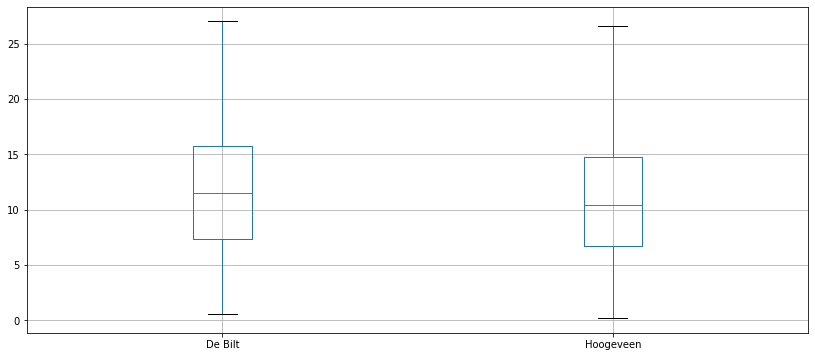

In [534]:
df_daily.boxplot(figsize=(14, 6))

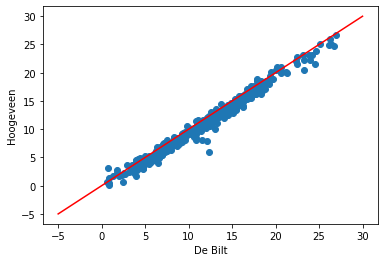

In [535]:
station1, station2 = stations.values()

plt.scatter(df_daily[station1], df_daily[station2])
plt.plot([-5, 30], [-5, 30], color='r')
plt.xlabel(station1)
plt.ylabel(station2)
plt.show()

In [536]:
n_kouder = np.sum(df_daily[station2] < df_daily[station1])
n_totaal, _ = df_daily.shape

print('Op %d van de %d dagen (%.0f%%) is het kouder in %s dan in %s' % (n_kouder, 
                                                                        n_totaal, 
                                                                        100*n_kouder/n_totaal, 
                                                                        station2, 
                                                                        station1))

Op 312 van de 366 dagen (85%) is het kouder in Hoogeveen dan in De Bilt


#### Temperatuurverschil

In [537]:
diff = df_daily[station2] - df_daily[station1]
diff

DD
2020-01-01   -0.6
2020-01-02   -2.1
2020-01-03   -0.9
2020-01-04   -1.4
2020-01-05   -1.5
             ... 
2020-12-27   -0.6
2020-12-28   -0.1
2020-12-29   -0.5
2020-12-30   -1.1
2020-12-31   -0.2
Length: 366, dtype: float64

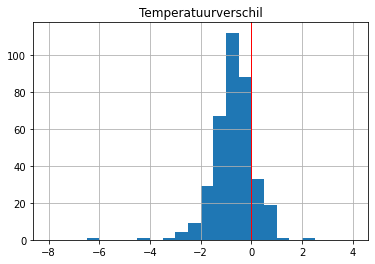

In [538]:
bins = np.arange(-8, 4.5, 0.5)
diff.hist(bins=bins)
plt.axvline(0, color='red', linewidth=1)
plt.title('Temperatuurverschil')
plt.show()

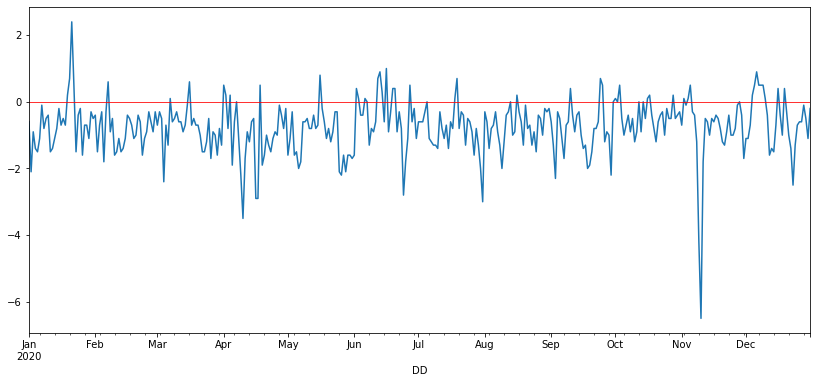

In [539]:
plt.figure(figsize=(14, 6))
diff.plot()
plt.axhline(0, color='red', linewidth=1, alpha=0.8)
plt.show()


## Student t-test

In [540]:
from scipy import stats
t, p = stats.ttest_1samp(diff, 0)
print("The t-statistic is %.3f and the p-value is %.5f." % (t, p/2))

The t-statistic is -18.156 and the p-value is 0.00000.


## Global Warming in Nederland

In [541]:
kwargs = {'skiprows' : 47, 
          'skipinitialspace': True,
          'usecols': ['YYYYMMDD', 'TG'],
          'parse_dates': ['YYYYMMDD'],
          'index_col': 0}

df = pd.read_csv(filename1, **kwargs)

In [542]:
df['TEMPERATURE'] = df['TG'] / 10

df.drop('TG', axis = 1, inplace = True)

In [543]:
df = df.truncate(before='1900-01-01', after='2020-12-31')

In [544]:
weekly = df.resample('W').mean()
monthly = df.resample('M').mean()
yearly = df.resample('Y').mean()

In [545]:
yearly

,TEMPERATURE
YYYYMMDD,
1901-12-31,8.783562
1902-12-31,8.245205
1903-12-31,9.166575
1904-12-31,8.933607
1905-12-31,8.713699
...,...
2016-12-31,10.703279
2017-12-31,10.965753
2018-12-31,11.401644


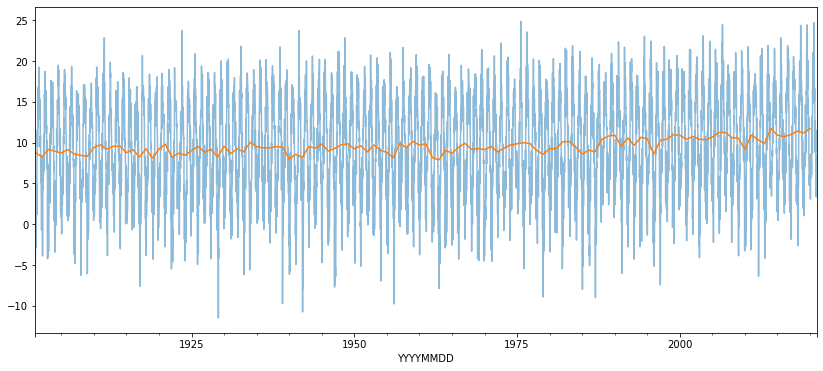

In [546]:
plt.figure(figsize=(14, 6))
weekly['TEMPERATURE'].plot(alpha=0.5)
yearly['TEMPERATURE'].plot()
plt.show()

### Fit polynomial model

In [547]:
model = np.polynomial.Polynomial.fit(yearly.index.year, yearly['TEMPERATURE'], deg = 5)

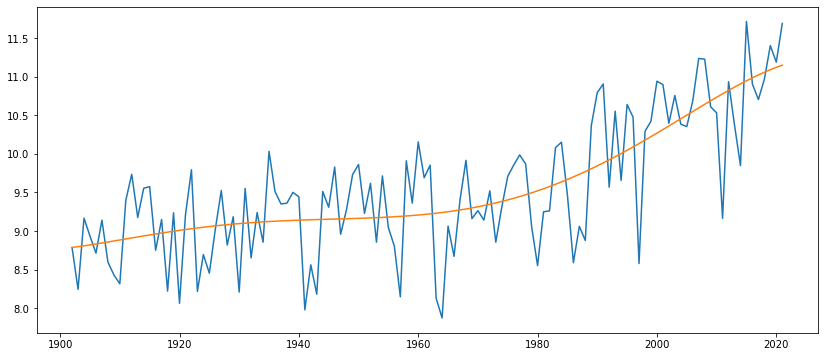

In [548]:
plt.figure(figsize=(14, 6))
plt.plot(yearly['TEMPERATURE'])
plt.plot(yearly.index, model(yearly.index.year))
plt.show()

In [549]:
def my_model(t, level0, year1, slope1):
    years = int(year1)
    days = int((year1 - years) * 365.2425)
    t1 = np.datetime64(str(years), 'D') + np.timedelta64(days, 'D')
    return np.where(t < t1, level0, level0 + (t - t1).days * slope1)

In [552]:
y = my_model(yearly.index, level0 = 12.0, year1 = 1980, slope1 = 0.0003)
y

array([12.    , 12.    , 12.    , 12.    , 12.    , 12.    , 12.    ,
       12.    , 12.    , 12.    , 12.    , 12.    , 12.    , 12.    ,
       12.    , 12.    , 12.    , 12.    , 12.    , 12.    , 12.    ,
       12.    , 12.    , 12.    , 12.    , 12.    , 12.    , 12.    ,
       12.    , 12.    , 12.    , 12.    , 12.    , 12.    , 12.    ,
       12.    , 12.    , 12.    , 12.    , 12.    , 12.    , 12.    ,
       12.    , 12.    , 12.    , 12.    , 12.    , 12.    , 12.    ,
       12.    , 12.    , 12.    , 12.    , 12.    , 12.    , 12.    ,
       12.    , 12.    , 12.    , 12.    , 12.    , 12.    , 12.    ,
       12.    , 12.    , 12.    , 12.    , 12.    , 12.    , 12.    ,
       12.    , 12.    , 12.    , 12.    , 12.    , 12.    , 12.    ,
       12.    , 12.    , 12.1095, 12.219 , 12.3285, 12.438 , 12.5478,
       12.6573, 12.7668, 12.8763, 12.9861, 13.0956, 13.2051, 13.3146,
       13.4244, 13.5339, 13.6434, 13.7529, 13.8627, 13.9722, 14.0817,
       14.1912, 14.3

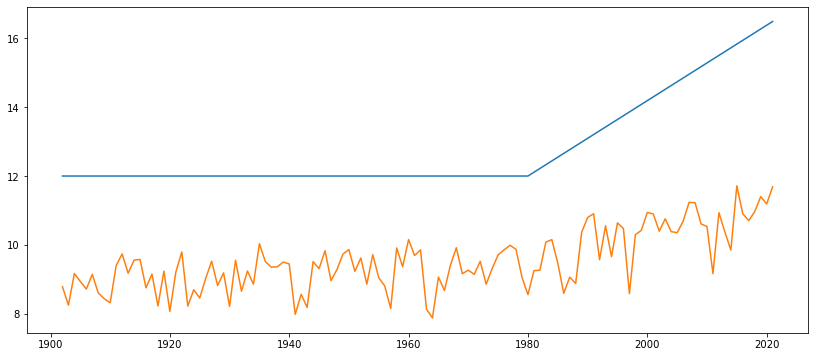

In [551]:
plt.figure(figsize=(14, 6))
plt.plot(dt, y)
plt.plot(yearly.index, yearly['TEMPERATURE'])
plt.show()

In [401]:
from scipy import optimize

In [508]:
popt, _ = optimize.curve_fit(my_model, 
                             xdata = yearly.index, 
                             ydata = yearly['TEMPERATURE'], 
                             p0 = [8, 1997, 8e-5],
                             bounds = [(7, 1930, 0), (11, 2010, 0.01)],
                             method='trf'   #‘lm’, ‘trf’, ‘dogbox’
                            )

print(popt)

[9.10190637e+00 1.99387059e+03 2.52392426e-04]


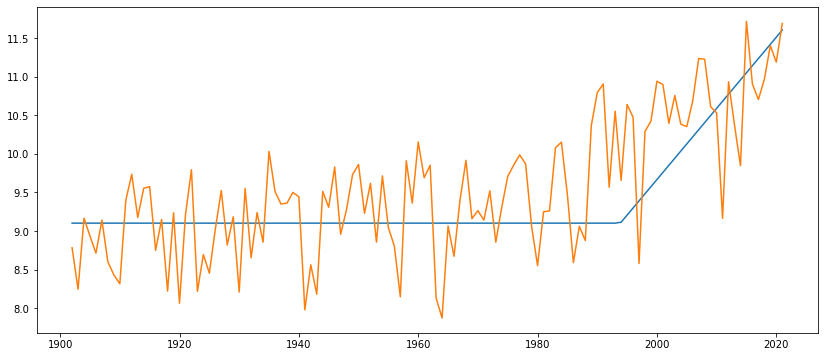

In [509]:
plt.figure(figsize = (14, 6))
plt.plot(yearly.index, my_model(yearly.index, *popt))
plt.plot(yearly.index, yearly['TEMPERATURE'])
plt.show()

In [510]:
def errors_squared(y_data, y_model):
    return np.min((y_data - y_model) ** 2)

In [511]:
errors_squared(yearly['TEMPERATURE'], my_model(yearly.index, *popt))

0.00027956586645779517

In [512]:
from functools import partial

errors = []
for year in range(1950, 2020):

    popt, _ = optimize.curve_fit(my_model, 
                                 xdata = yearly.index, 
                                 ydata = yearly['TEMPERATURE'],
                                 p0 = [8, year, 8e-5],
                                 bounds = [(8, 1950, 7e-5), (10, 2020, 10e-5)],
                                 method='trf'   #‘lm’, ‘trf’, ‘dogbox’
                                )    

    errors.append( errors_squared(yearly['TEMPERATURE'], my_model(yearly.index, *popt)) )
    
errors = np.array(errors)

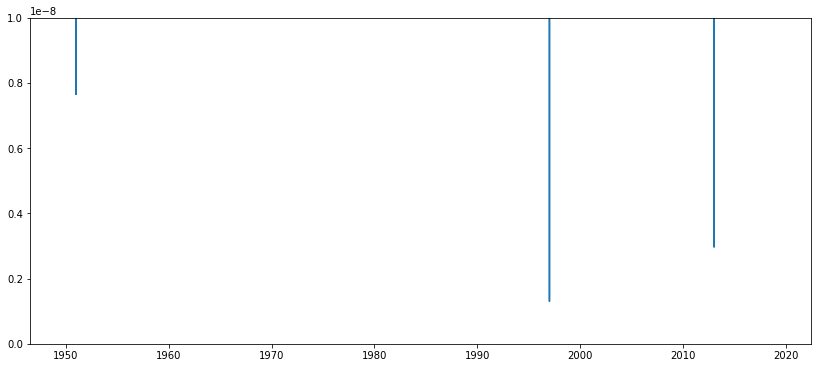

In [513]:
plt.figure(figsize = (14, 6))
plt.plot(range(1950, 2020), errors)
plt.ylim(0, 0.00000001)
plt.show()

In [497]:
1950 + errors.argmin()

1997

In [27]:
import re

def read_parts(filename):
    REGEX_DISCLAIMER = r'^BRON:|^SOURCE:'
    REGEX_DISCRIPTION = r'^\w+\s+='
    REGEX_HEADER = r'^# STN'
    REGEX_DATA = r'^\s*\d{3},'

    with open(filename) as f:
        in_part = False
        for line in f:
            if not in_part:
                if re.match(REGEX_DISCLAIMER, line):
                    print('regex_disclaimer_part')
                    in_part = True
                    skip_part = True
                    continue
                elif re.match(REGEX_DISCRIPTION, line):
                    print('regex_discription_part')
                    in_part = True
                    skip_part = True
                    continue
                elif re.match(REGEX_HEADER, line):
                    print('regex_header_part')
                    in_part = True
                    skip_part = False
                    yield line.lstrip('# ')
                elif re.match(REGEX_DATA, line):
                    print('regex_data_part')
                    in_part = True
                    skip_part = False
                    yield line
            else:
                if line.strip() == '':
                    in_part = False
                elif not skip_part:
                    yield line


def bad_lines(line):
    REGEX_DISCLAIMER = r'^BRON:|^SOURCE:'
    REGEX_DISCRIPTION = r'^\w+\s+='
    REGEX_HEADER = r'^# STN'
    REGEX_DATA = r'^\s*\d{3},'

    if re.match(REGEX_DISCLAIMER, line):
        return 'skip'
    elif re.match(REGEX_DISCRIPTION, line):
        return 'skip'
    elif line.strip() == '':
        return 'skip'
    else:
        return None


    
    
df = pd.read_csv(filename1, on_bad_lines = bad_lines)
df


ValueError: on_bad_line can only be a callable function if engine='python'